In [1]:
! pip install cmake

In [2]:
! pip install dlib

In [11]:
! pip install face_recognition


  Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
  Using cached face_recognition_models-0.3.0.tar.gz (100.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=b591c0626a91116ef54f47f9affe40719a881f3e66ffd70f61d244fd312e3a91
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import cv2
import numpy as np
import face_recognition
import csv
import os
from datetime import datetime

path = "/content/drive/MyDrive/face_recognition"
images = []
classnames = []
my_list = os.listdir(path)
print(my_list)

['mohanlal.jpg', 'Dona.jpg']


In [69]:
for cl in my_list:
    curImg = cv2.imread(f'{path}/{cl}')
    images.append(curImg)
    classnames.append(os.path.splitext(cl)[0])
print(classnames)

['mohanlal', 'Dona']


In [70]:
def findEncodings(images):
    encode_list = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encode_list.append(encode)
    return encode_list

In [71]:

# now = datetime.now()
# current_date = now.strftime("%Y-%m-%d")
# f = open(current_date+'.csv','w+', newline='')
# name_list = []

# def markAttendance(name):
#     if name not in name_list:
#         f = open(current_date+'.csv','a+', newline='')
#         name_list.append(name)
#         time_now = datetime.now()
#         tString = time_now.strftime('%H:%M:%S')
#         dString = time_now.strftime('%d/%m/%Y')
#         f.writelines(f'\n{name},{tString},{dString}')

#simple method...(from chatgpt)
time_now = datetime.now()
tString = time_now.strftime('%H:%M:%S')
dString = time_now.strftime('%d/%m/%Y')



In [72]:
def update_attendance(name):

    with open('attendance_records.csv','a+',newline ='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([dString, tString, name])

    with open('attendance_records.csv','r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            if row[0] == dString and row[2] == name:
                return

In [73]:
encode_list_known = findEncodings(images)
print('Encoding Complete')

Encoding Complete


In [74]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


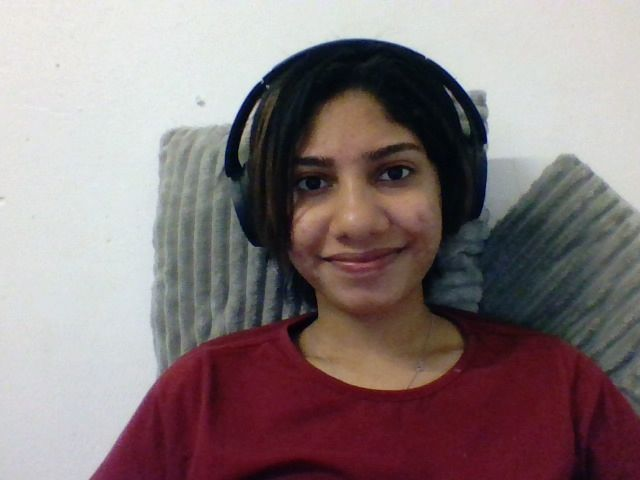

In [39]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

[0.85986402 0.43259872]
DONA


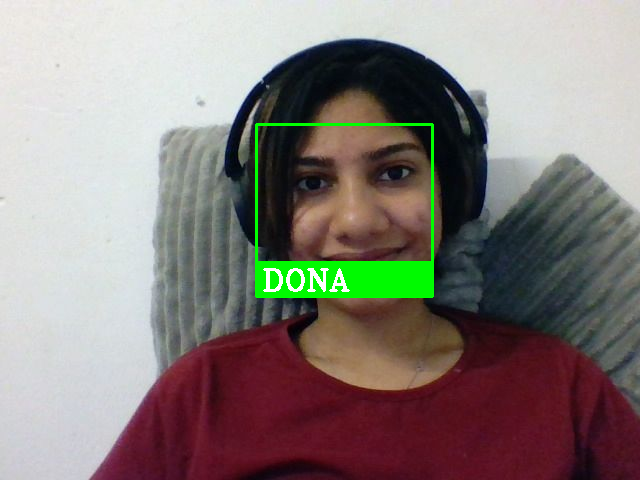

In [75]:
from google.colab.patches import cv2_imshow
img = cv2.imread(filename)
imgS = cv2.resize(img, (0, 0), None, 0.25, 0.25)
imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

imgS = cv2.resize(img, (0, 0), None, 0.25, 0.25)
imgS = cv2.cvtColor(imgS, cv2.COLOR_BGR2RGB)

facesCurFrame = face_recognition.face_locations(imgS)
encodesCurFrame = face_recognition.face_encodings(imgS, facesCurFrame)

for encodeFace, faceLoc in zip(encodesCurFrame, facesCurFrame):
    matches = face_recognition.compare_faces(encode_list_known, encodeFace)
    faceDis = face_recognition.face_distance(encode_list_known, encodeFace)
    print(faceDis)
    matchIndex = np.argmin(faceDis)
    if matches[matchIndex]:
        name = classnames[matchIndex].upper()
        print(name)
        y1, x2, y2, x1 = faceLoc
        y1, x2, y2, x1 = y1*4, x2*4, y2*4, x1*4
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.rectangle(img, (x1, y2-35), (x2, y2), (0, 250, 0), cv2.FILLED)
        cv2.putText(img, name, (x1+6, y2-6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
        update_attendance(name)
    else:
        name = 'STRANGER'
        print(name)
        y1, x2, y2, x1 = faceLoc
        y1, x2, y2, x1 = y1*4, x2*4, y2*4, x1*4
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.rectangle(img, (x1, y2-35), (x2, y2), (0, 250, 0), cv2.FILLED)
        cv2.putText(img, name, (x1+6, y2-6), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
cv2_imshow(img)
